In [1]:
"""Bayesian way"""
import arviz as az
import stan
import nest_asyncio
nest_asyncio.apply()

"""Basic ones"""
import polars as pl
from plotnine import *
import matplotlib.pyplot as plt
plt.show()  # for display figures after ggplot
plt.style.use("ggplot")
# plt.rcParams["axes.grid"] = True
import numpy as np
import seaborn as sns
import pandas
import statsmodels.api as sm
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.signal import medfilt
from statsmodels.graphics.tsaplots import plot_acf


import warnings
warnings.simplefilter("ignore")

weather_columns = ["date", "day_of_week", "mean_press", "min_press_sea", "mean_press_sea", "mean_vapor", "mean_hum",
                    "min_hum", "total_preci", "hourly_max_preci", "max_depth", "total_snowfall", "sun_hour",
                    "mean_temp", "max_temp", "min_temp", "mean_wind_speed", "max_wind_speed", "max_gust", 
                    "most_direction", "most_direction_dummy"]

In [3]:
!conda list | grep polars

polars                    0.20.19         py311h78b473b_0    conda-forge


In [10]:
# hrv = pl.read_csv("../../data/HRV/hrv.csv")
# hrv.with_columns(pl.col("date").str.replace_all("/", "-")).write_csv("../../data/HRV/hrv.csv")

In [2]:
df_weather = pl.read_csv("../../data/weather/weather.csv")
df_weather = df_weather[23:] # because of weather data starts from 2024/07/01
df_hrv = pl.read_csv("../../data/HRV/hrv.csv")
# df = df_weather.join(df_hrv, on="date", how="left") 
df = df_hrv.join(df_weather, on="date")

# convert day of week into dummy variable
days_of_week = ["日", "月", "火", "水", "木", "金", "土"]
day_to_label = {day: idx for idx, day in enumerate(days_of_week)}
df = df.with_columns(
    pl.col("day_of_week").apply(lambda day: day_to_label[day]).alias("day_of_week")
)
df.head()

date,VLF,LF,HF,LFHFratio,HR,SDNN,RMSSD,pNN50,TINN,CD,ApEn,SD1,SD2,SD1SD2ratio,day_of_week,mean_press,min_press_sea,mean_press_sea,mean_vapor,mean_hum,min_hum,total_preci,hourly_max_preci,max_depth,total_snowfall,sun_hour,mean_temp,max_temp,min_temp,mean_wind_speed,max_wind_speed,max_gust,most_direction,most_direction_dummy
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,str,i64
"""2017-07-24""",884.554467,176.079683,98.624315,1.785358,89.918794,50.293799,20.861884,0.024854,226.5625,0.208329,0.922786,14.75156,69.499062,0.212256,1,978.5,1000.6,1002.5,29.1,99,93,50.5,8.0,0,0,0.0,23.7,25.1,23.1,0.9,2.9,4.0,"""北北西""",15
"""2017-07-25""",1077.163019,409.565228,692.82705,0.591151,88.932674,60.827421,57.237082,0.122433,156.25,0.207682,0.901482,40.472728,75.529353,0.535854,2,979.6,1002.1,1003.6,28.6,95,85,8.0,1.5,0,0,0.0,24.1,25.7,22.3,0.9,2.2,3.2,"""北北西""",15
"""2017-07-26""",833.683813,284.855324,167.546256,1.700159,93.593945,51.727819,27.178771,0.031002,195.3125,0.1454239,0.634698,19.218055,70.521594,0.272513,3,983.1,1004.9,1007.2,24.0,73,51,0.0,0.0,0,0,10.2,25.9,31.5,22.0,2.1,5.3,9.7,"""東南東""",5
"""2017-07-27""",1636.069588,293.085583,222.901403,1.314866,83.92394,75.542652,38.155843,0.062075,304.6875,0.16728,0.728771,26.979802,102.905322,0.262181,4,986.1,1008.8,1010.2,21.9,68,54,0.0,0.0,0,0,4.7,25.4,30.3,21.0,2.7,5.0,7.9,"""東""",4
"""2017-07-28""",994.366727,335.918425,517.969574,0.648529,90.402819,59.249159,41.522311,0.053435,171.875,0.140829,0.58117,29.360692,78.456813,0.374227,5,984.8,1006.4,1008.8,28.0,84,57,39.5,27.5,0,0,2.5,26.1,32.1,22.6,1.5,6.4,10.0,"""北西""",14


In [12]:
df_weather.filter(pl.col("date").str.contains("08-01"))

date,day_of_week,mean_press,min_press_sea,mean_press_sea,mean_vapor,mean_hum,min_hum,total_preci,hourly_max_preci,max_depth,total_snowfall,sun_hour,mean_temp,max_temp,min_temp,mean_wind_speed,max_wind_speed,max_gust,most_direction,most_direction_dummy
str,str,f64,f64,f64,f64,i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,str,i64
"""2017-08-01""","""火""",985.1,1007.7,1009.3,25.9,84,65,2.0,1.0,0,0,0.6,24.6,28.8,21.5,1.6,4.6,7.3,"""西北西""",13
"""2018-08-01""","""水""",980.4,1001.3,1004.0,24.2,61,32,0.0,0.0,0,0,13.0,29.7,37.4,24.3,2.6,6.8,10.9,"""北西""",14
"""2019-08-01""","""木""",988.2,1009.9,1012.0,28.2,71,46,0.0,0.0,0,0,12.1,29.4,35.6,25.0,2.1,5.4,8.9,"""北北西""",15
"""2020-08-01""","""土""",988.2,1010.0,1012.5,24.8,83,53,7.0,7.0,0,0,7.2,24.4,30.9,20.2,1.5,4.3,7.7,"""北西""",14
"""2021-08-01""","""日""",978.9,1001.1,1002.7,26.9,75,51,0.0,0.0,0,0,5.8,27.3,33.7,23.1,1.8,4.6,7.0,"""北""",16
"""2022-08-01""","""月""",989.0,1010.0,1012.8,28.3,70,39,0.0,0.0,0,0,12.1,29.9,37.4,23.8,1.7,3.8,6.2,"""北西""",14
"""2023-08-01""","""火""",988.8,1010.0,1012.9,27.0,80,55,7.0,7.0,0,0,5.7,26.2,32.3,21.1,1.7,7.1,11.6,"""西北西""",13


In [13]:
# to make dataframe with no nan values in weather columns
# df = df.to_pandas()
# for i in weather_columns[2:-2]:
#     df[i] = df[i].fillna(np.mean(df[i]))
# df = pl.from_pandas(df)

In [14]:
# df[weather_columns].write_csv("../../data/weather/weather.csv")

<Axes: ylabel='Density'>

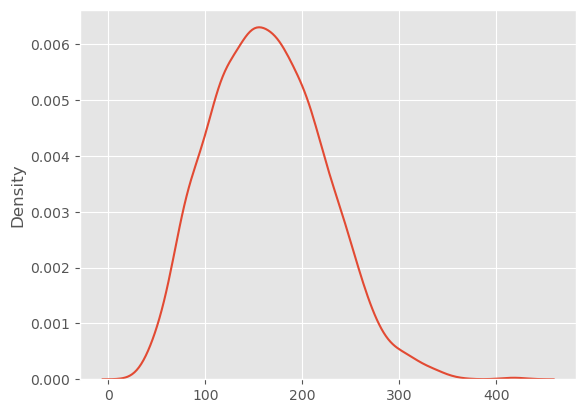

In [15]:
# plt.hist(df_hrv["HR"], bins=50);
sns.kdeplot(df_hrv["TINN"])

In [16]:
y_filter = df["RMSSD"][0:].rolling_mean(3, center=True).to_numpy()
# y = medfilt(df["RMSSD"][0:200], 5)
y = df["RMSSD"][0:].to_numpy()
features = df[weather_columns][0:].drop(["date", "most_direction"])
features.head()

day_of_week,mean_press,min_press_sea,mean_press_sea,mean_vapor,mean_hum,min_hum,total_preci,hourly_max_preci,max_depth,total_snowfall,sun_hour,mean_temp,max_temp,min_temp,mean_wind_speed,max_wind_speed,max_gust,most_direction_dummy
i64,f64,f64,f64,f64,i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64
1,978.5,1000.6,1002.5,29.1,99,93,50.5,8.0,0,0,0.0,23.7,25.1,23.1,0.9,2.9,4.0,15
2,979.6,1002.1,1003.6,28.6,95,85,8.0,1.5,0,0,0.0,24.1,25.7,22.3,0.9,2.2,3.2,15
3,983.1,1004.9,1007.2,24.0,73,51,0.0,0.0,0,0,10.2,25.9,31.5,22.0,2.1,5.3,9.7,5
4,986.1,1008.8,1010.2,21.9,68,54,0.0,0.0,0,0,4.7,25.4,30.3,21.0,2.7,5.0,7.9,4
5,984.8,1006.4,1008.8,28.0,84,57,39.5,27.5,0,0,2.5,26.1,32.1,22.6,1.5,6.4,10.0,14


In [17]:
df_hrv.filter(pl.col("RMSSD") > 100)

date,VLF,LF,HF,LFHFratio,HR,SDNN,RMSSD,pNN50,TINN,CD,ApEn,SD1,SD2,SD1SD2ratio
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""2017-08-07""",351.429013,333.462963,225.295859,1.480111,72.472948,137.359985,131.684498,0.135667,132.8125,0.333666,0.65378,93.114933,170.078803,0.547481
"""2017-12-27""",745.721658,940.854005,1759.235511,0.534808,90.436588,92.005224,103.364464,0.219613,328.125,0.138249,0.58714,73.089624,107.578337,0.679408
"""2022-10-23""",708.175972,126.894929,222.836062,0.569454,72.723005,110.208006,102.963025,0.101681,187.5,0.275481,0.708792,72.8054,137.418037,0.52981


In [18]:
scaler = StandardScaler()
features_std = scaler.fit_transform(features.drop(["day_of_week", "most_direction_dummy"]).to_numpy())
features_std = pl.DataFrame(features_std, schema=features.columns[1:-1])
features_std.describe()

statistic,mean_press,min_press_sea,mean_press_sea,mean_vapor,mean_hum,min_hum,total_preci,hourly_max_preci,max_depth,total_snowfall,sun_hour,mean_temp,max_temp,min_temp,mean_wind_speed,max_wind_speed,max_gust
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2274.0,2274.0,2274.0,2274.0,2274.0,2274.0,2274.0,2274.0,2274.0,2274.0,2274.0,2274.0,2274.0,2274.0,2274.0,2274.0,2274.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",-6.9492e-15,8.1241e-15,-2.2872e-15,NaN,NaN,NaN,NaN,NaN,-8.4365e-17,-1.0936e-17,NaN,6.2493e-17,-1.6248e-16,-1.1249e-16,NaN,NaN,NaN
"""std""",1.00022,1.00022,1.00022,NaN,NaN,NaN,NaN,NaN,1.00022,1.00022,NaN,1.00022,1.00022,1.00022,NaN,NaN,NaN
"""min""",-3.513468,-5.204173,-3.458235,-1.300319,-3.645259,-2.852076,-0.425509,-0.447409,-0.339057,-0.22723,-1.184156,-2.075502,-2.224006,-2.253536,-1.516685,-1.966016,-1.870733
"""25%""",-0.672337,-0.65575,-0.702044,-0.871422,-0.584823,-0.61434,-0.425509,-0.447409,-0.339057,-0.22723,-0.936524,-0.919063,-0.891864,-0.887986,-0.764514,-0.732265,-0.740991
"""50%""",-0.033881,-0.017861,-0.031225,-0.325552,0.084647,0.007253,-0.425509,-0.447409,-0.339057,-0.22723,-0.168865,-0.027863,0.063803,-0.107672,-0.294407,-0.020486,-0.014729
"""75%""",0.716305,0.689363,0.741676,0.75319,0.754118,0.691006,-0.019142,0.070395,-0.339057,-0.22723,0.7969,0.873947,0.845712,0.900234,0.551785,0.691293,0.684635
"""max""",2.903018,2.866504,2.856214,2.247834,1.99742,2.680104,12.510515,19.056551,6.834099,19.591182,2.332219,1.892462,1.926871,1.962329,5.346874,4.01293,4.961513


In [19]:
# pl.concat([df[["date", "day_of_week"]], features_std], how="horizontal").fill_nan(0).write_csv("../../data/weather/weather_std.csv")

In [20]:
# df.drop(weather_columns).write_csv("../../data/HRV/hrv_date_adjusted.csv")
# pl.concat([df_weather[["date", "day_of_week"]], features_std], how="horizontal").fill_nan(0).write_csv("../../data/weather/weather_std_date_adjusted.csv")

In [21]:
n_sample = len(features) # number of samples
y = y # medfilt(y, 11)
# data for stan code
data = {
    "n_sample": n_sample,
    # "n_features": features.columns,
    "mean_press": features_std["mean_press"].to_numpy(), 
    "mean_hum": features_std["mean_hum"].to_numpy(),
    "mean_temp": features_std["mean_temp"].to_numpy(),
    "mean_wind_speed": features_std["mean_wind_speed"].to_numpy(),
    "sun_hour": features_std["sun_hour"].to_numpy(),
    "total_preci": features_std["total_preci"].to_numpy(),
    "total_snowfall": features_std["total_snowfall"].to_numpy(),
    "y": y
}
# (features_std["mean_press"]-features_std.with_columns(pl.col("mean_press").rolling_mean(7))["mean_press"]).to_numpy()

In [9]:
# https://discourse.mc-stan.org/t/pystan-init-values/26008
init_dict = {}
init_dict["mu"] = [100]*n_sample
init_dict["sigma_w"] = 100
init_dict["sigma_v"] = 100
init_dict["b_1"] = -1
init_dict["b_2"] = -1
def stan_init(init_dict: dict):
    res = {}
    for name, dict_ in init_dict.items():
        res[name] = dict_
    return res

In [15]:
with open("model/basic.stan", "r") as fstan:
    posterior = stan.build(fstan.read(), data=data, random_seed=1023)
fit = posterior.sample(num_chains=4, num_samples=1000, num_warmup=1000,)
                        # init=[stan_init(init_dict)]*4)
result = fit.to_frame()
result = result.drop(['accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__',], axis=1)

Building...



Building: found in cache, done.Messages from stanc:
    bound in its declaration. These hard constraints are not recommended, for
    two reasons: (a) Except when there are logical or physical constraints,
    it is very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
    its declaration. These hard constraints are not recommended, for two
    reasons: (a) Except when there are logical or physical constraints, it is
    very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause diffic

In [16]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],39.702,3.094,33.929,45.469,0.052,0.037,3513.0,3246.0,1.0
mu[1],39.796,2.993,34.086,45.279,0.049,0.035,3684.0,3334.0,1.0
mu[2],39.809,2.893,34.462,45.127,0.048,0.034,3585.0,3147.0,1.0
mu[3],39.871,2.804,34.625,45.036,0.047,0.033,3512.0,3196.0,1.0
mu[4],39.953,2.743,34.732,45.020,0.047,0.033,3416.0,3048.0,1.0
...,...,...,...,...,...,...,...,...,...
y_pred[2269],20.282,12.721,-2.280,45.391,0.208,0.147,3747.0,3663.0,1.0
y_pred[2270],20.569,12.576,-1.574,44.967,0.197,0.141,4056.0,4014.0,1.0
y_pred[2271],19.991,12.426,-2.762,43.438,0.200,0.141,3870.0,3683.0,1.0
y_pred[2272],19.871,12.296,-3.076,43.063,0.198,0.141,3852.0,3813.0,1.0


In [17]:
mu_name = [f"mu.{i}" for i in range(1, n_sample+1)]
result_mu = result[mu_name].values
# result_mu[:, 0] # 1時点のサンプリングデータ
# result_mu[0, :] # 1 ~ 100時点の状態
# result[mu_name]

In [18]:
percentile = result[mu_name].apply(np.percentile, axis=0, args=([2.5, 50, 97.5],))
percentile = percentile.T
percentile.columns = ["lwr", "fit", "upr"]
percentile

,lwr,fit,upr
parameters,,,
mu.1,33.670183,39.729541,45.725262
mu.2,33.899428,39.824451,45.601213
mu.3,34.247295,39.820261,45.436521
mu.4,34.399554,39.901629,45.240947
mu.5,34.524012,40.021251,45.258787
...,...,...,...
mu.2270,14.372661,19.959124,25.463891
mu.2271,14.358592,19.964553,25.674985
mu.2272,14.167730,20.014280,25.803526


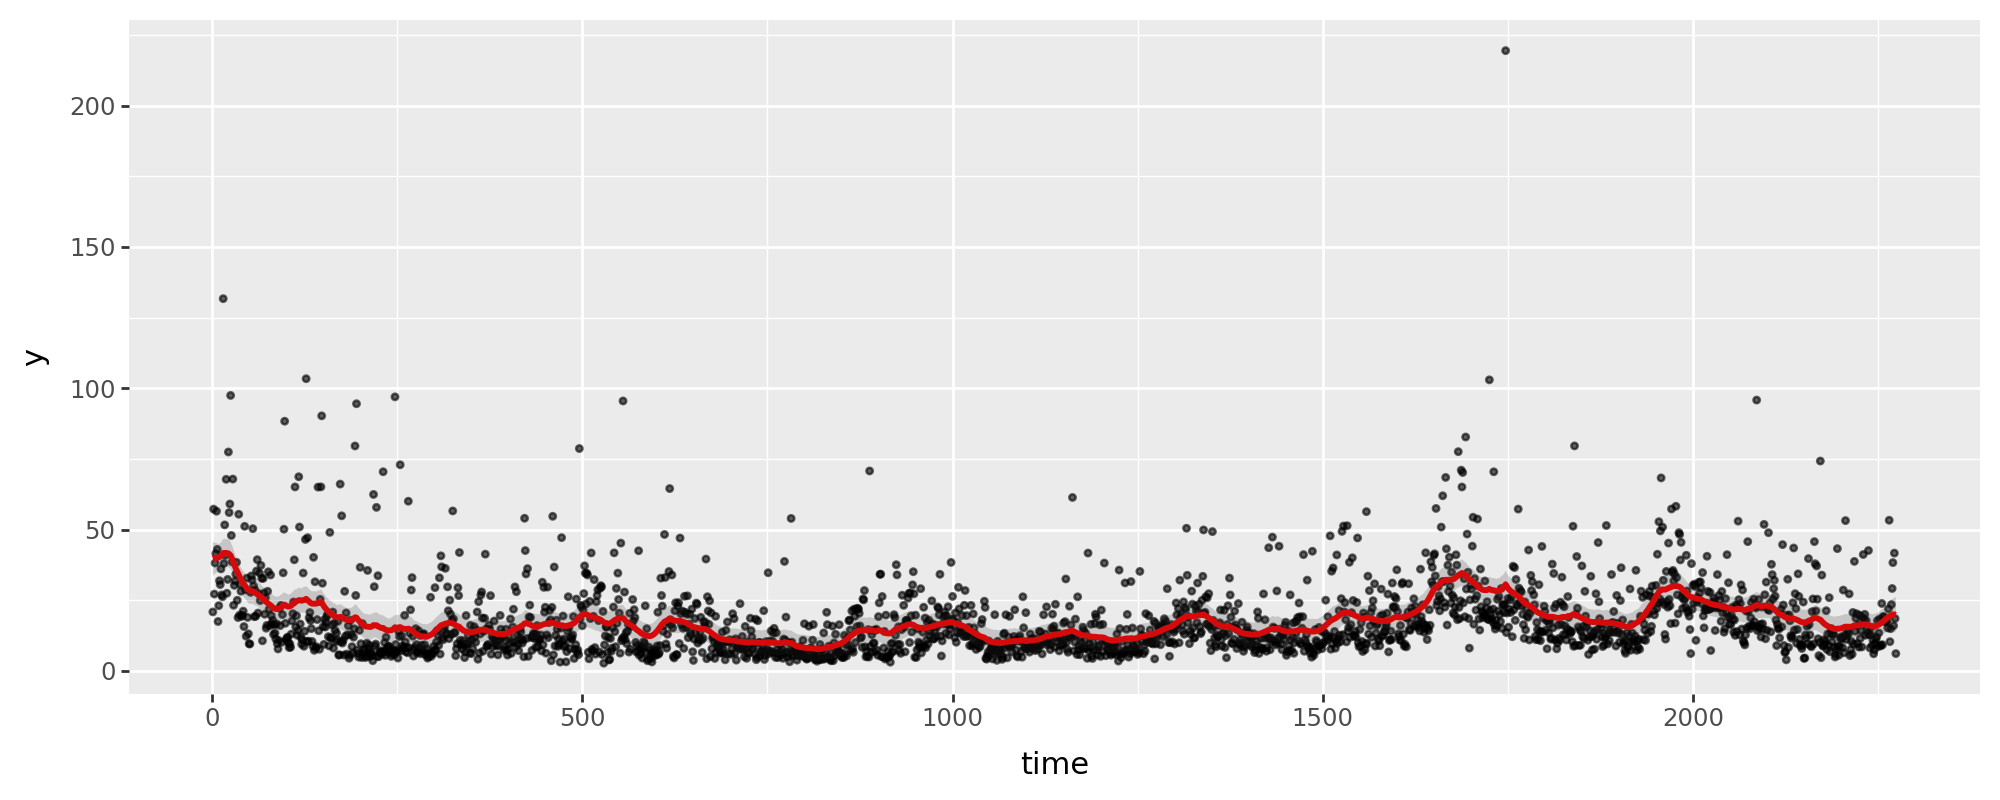

In [20]:
percentile["y"] = y
percentile["time"] = range(1, len(percentile)+1)
(
    ggplot(percentile, aes(x="time"))
    + geom_point(aes(y="y"), alpha=0.6, size=0.8)
    + geom_line(aes(y="fit"), size=1.2, color="red")
    + geom_ribbon(aes(ymin="lwr", ymax="upr"), alpha=0.2)
    + theme(figure_size=(10, 4))
    + ggtitle("")
)

In [21]:
az.summary(fit).query("r_hat > 1.1")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_w,0.823,0.106,0.623,1.029,0.018,0.013,35.0,57.0,1.13


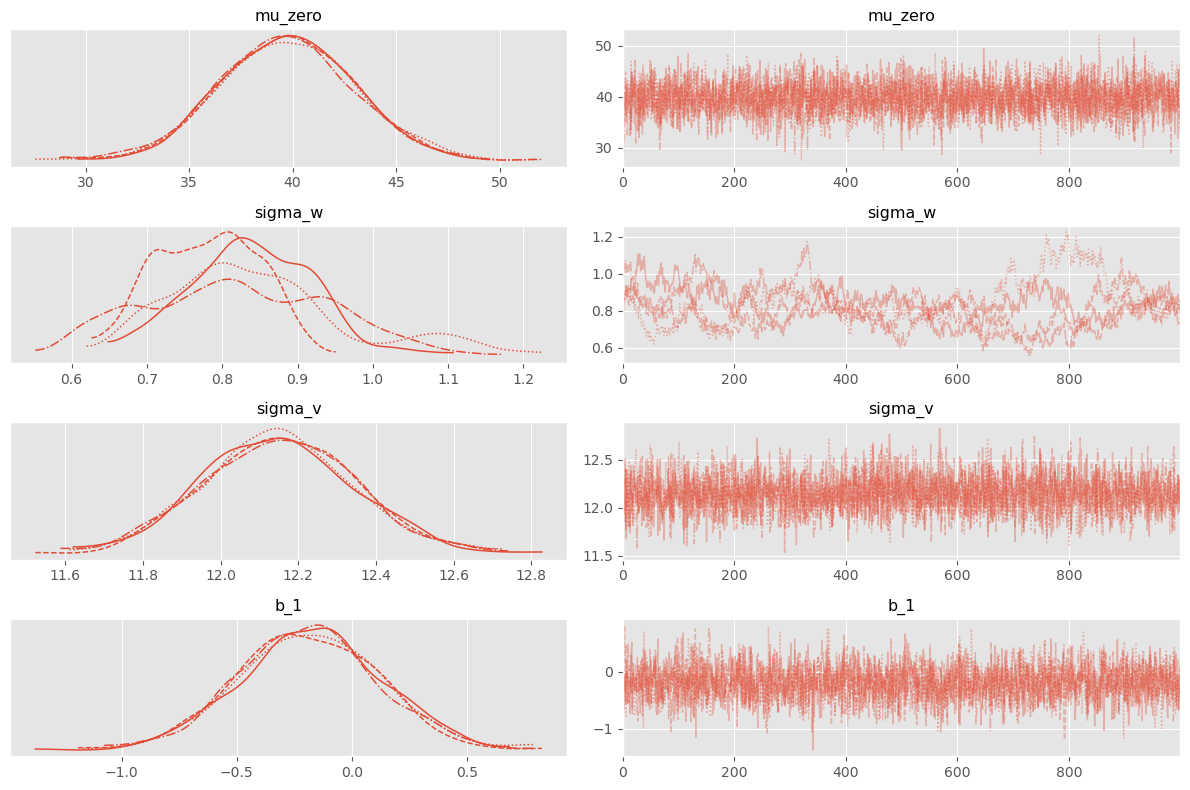

In [22]:
az.plot_trace(fit, var_names=["mu_zero", "sigma_w", "sigma_v", "b_1"])
plt.tight_layout()

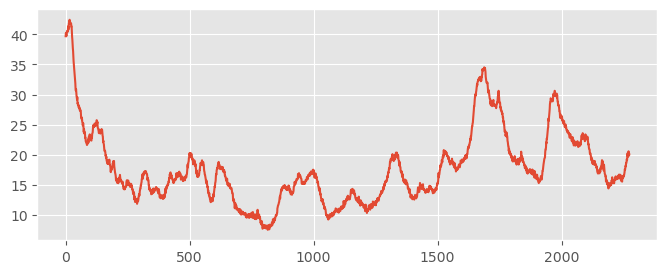

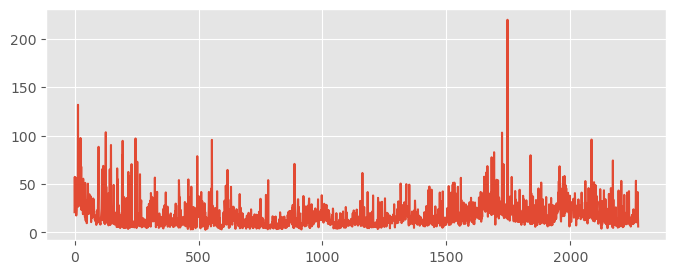

In [23]:
plt.figure(figsize=(8,3))
plt.plot(fit["y_pred"].mean(axis=1))
plt.figure(figsize=(8,3))

plt.plot(y)

In [38]:
# https://qiita.com/kromiii/items/c17070e3b242b0d62c39
def waic(fit):
    log_lik = fit['log_lik']
    print(log_lik.shape)
    lppd = np.log(np.exp(log_lik).mean(axis=0)).sum()
    print(lppd.shape)
    p_waic = np.var(log_lik, axis=0).sum()
    print(p_waic.shape)
    waic = -2*lppd + 2*p_waic
    return round(waic, 3)

In [42]:
waic(fit)

(2274, 4000)
()
()


100210.995

In [41]:
az.waic(fit)

Computed from 4000 posterior samples and 2274 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -8955.43   154.05
p_waic       96.11        -

There has been a warning during the calculation. Please check the results.

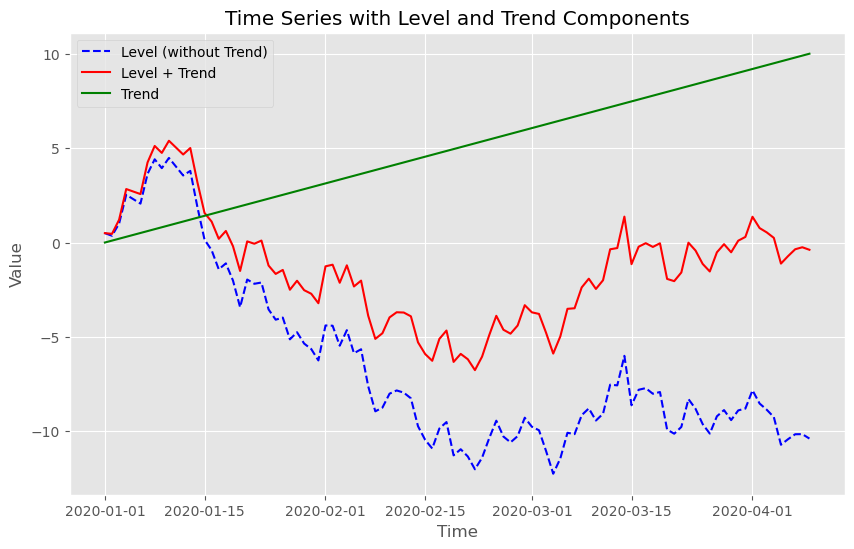

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# サンプルの時系列データを生成
np.random.seed(42)
T = 100  # 時系列の長さ
time = pd.date_range(start="2020-01-01", periods=T, freq="D")
level = np.random.normal(0, 1, T).cumsum()  # ランダムウォークとして水準を生成
trend = np.linspace(0, 1, T) * 10  # トレンド成分
data_with_trend = level + trend  # 水準にトレンドを加えたデータ

# プロット
plt.figure(figsize=(10, 6))
plt.plot(time, level, label="Level (without Trend)", linestyle="--", color="blue")
plt.plot(time, data_with_trend, label="Level + Trend", color="red")
plt.plot(time, trend, label="Trend", color="green")

plt.title("Time Series with Level and Trend Components")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()
